# Qiskit Basics

This notebook demonstrates the essential process of creating and executing quantum circuits, both through local simulation and on IBM's quantum hardware.
Throughout this guide, we'll explore the core steps of quantum-classical computation, providing executable examples that you can adapt for optimization problems and further experimentation.

## Qiskit Workflow

Modern quantum computing implementations follow a hybrid quantum-classical workflow that combines classical preprocessing with quantum execution.
This approach consists of designing quantum circuits on classical hardware, optimizing them for specific quantum devices, executing them (either through simulation or on physical quantum hardware), and analyzing the resulting measurements.
The workflow we'll explore consists of four key stages:
1. **Map**: Transform the problem into quantum circuits and operators.
    * Formalize the computational problem and express potential solutions through appropriate circuit encodings.
2. **Optimize**: Adapt circuits for the target quantum hardware.
    * Different quantum backends have varying topologies and supported gate sets; circuits must be transformed (transpiled) to ensure compatibility with the chosen device.
3. **Execute**: Run circuits either on a quantum simulator or submit jobs to a quantum backend.
4. **Post-Process**: Transform measurement outcomes into meaningful results.
    * Convert raw measurements into probabilities or objective values.
    * Visualize results and extract optimal solutions.

This systematic approach forms the foundation for many quantum algorithms in optimization and chemistry, including QAOA (Quantum Approximate Optimization Algorithm) and VQE (Variational Quantum Eigensolver).
Moreover, this workflow pattern generalizes well to other quantum computing frameworks such as Cirq and Q#.
The following sections demonstrate this workflow through practical examples.

In [ ]:
%pip install -U qiskit qiskit-aer qiskit-ibm-runtime matplotlib

## Qiskit Local Simulation

### Map

The simulation phase begins with constructing a quantum circuit for analysis.
The ability to map problems to appropriate quantum circuits is a fundamental skill in quantum optimization: it requires carefully choosing an encoding that effectively represents candidate solutions as quantum states.

For this demonstration, we'll create a Bell state using Qiskit's `QuantumCircuit` class.
This class provides an intuitive and powerful framework for circuit construction, manipulation, and visualization.

#### Example: Bell State Construction

We'll follow these steps to create a Bell state:
1. Initialize a circuit with two qubits.
2. Apply a Hadamard gate (`H`) to the first qubit, followed by a CNOT gate (`CX`) from qubit 0 to qubit 1.
3. Add measurement operations to all qubits.

The resulting circuit can be visualized using the circuit's `draw()` method, which provides a clear representation of the quantum operations.

In [2]:
from qiskit import QuantumCircuit

# Define a quantum circuit using two qubits.

qc = QuantumCircuit(2)

# Build a quantum circuit.

qc.h(0)
qc.cx(0, 1)

# Measure every qubit on the circuit at the same time.

qc.measure_all()

# Draw the quantum circuit.

qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

### Optimize

When working with a local simulator, circuit optimization is typically not required.
However, execution on actual quantum hardware necessitates circuit transformation to accommodate the device's physical constraints, including connectivity limitations and native gate sets. 
This transformation process, known as transpilation, optimizes routing overhead and ensures circuit compatibility with the target backend.

### Execute

In the following examples, we utilize the `SamplerV2` primitive from `qiskit_aer.primitives` to sample measurement outcomes and obtain statistical counts.
Note that when invoking the sampler, the circuit object must be passed within a list (e.g., `[qc]`).
The `shots` parameter controls the number of circuit repetitions.

For our Bell state example, we expect to observe approximately equal frequencies of the basis states `00` and `11`, each occurring roughly 50% of the time.

In [3]:
from qiskit_aer.primitives import SamplerV2 as Sampler

# Get the sampler and run the circuit.

sampler = Sampler()
job = sampler.run([qc], shots=10_000)

# Retrieve results from the sampler.

result = job.result()
counts = result[0].data.meas.get_counts()

### Post-Processing

The execution output consists of measured bit strings and their corresponding occurrence counts.
These raw measurements require careful interpretation and post-processing to extract meaningful insights.
The typical post-processing workflow includes:
* Normalizing counts to probability distributions.
* Mapping measured bit strings back to problem-specific solution candidates.
* Computing relevant metrics (e.g., objective function values or quantum expectation values).
* Generating visualizations and statistical summaries to facilitate result interpretation.

In quantum optimization workflows, sophisticated post-processing is crucial for translating quantum measurement distributions into practical solutions for the original optimization problem.

For our Bell state example, the measurement distribution should demonstrate approximately equal frequencies of `00` and `11` states (approximately 50% each).

Counts: {'11': 4976, '00': 5024}.


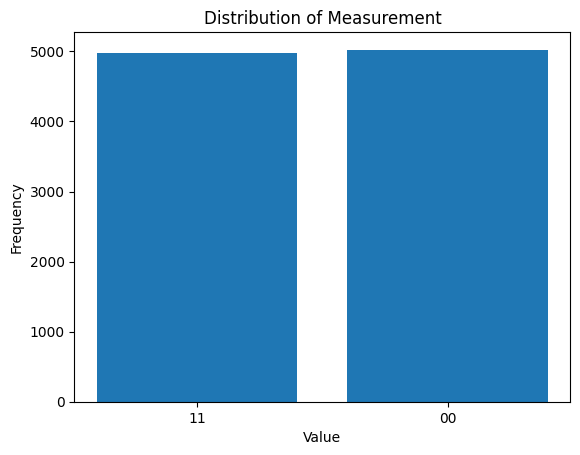

In [4]:
# Print the counts as Python dictionary form.

print(f"Counts: {counts}.")

# Plot the distribution on a histogram.

import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Measurement")
plt.show()

## Qiskit Quantum Backend

### Map

Similar to the simulation process, we begin by constructing our quantum circuit.
The circuit construction remains identical, as the logical structure of our quantum algorithm is independent of the execution platform.

In [5]:
from qiskit import QuantumCircuit

# Define a quantum circuit using two qubits.

qc = QuantumCircuit(2)

# Build a quantum circuit.

qc.h(0)
qc.cx(0, 1)

# Measure every qubit on the circuit at the same time.

qc.measure_all()

# Draw the quantum circuit.

qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

### Optimize

To execute circuits on IBM's quantum hardware, you must provide your IBM Quantum API token and Cloud Resource Name (CRN).
These credentials should be kept confidential and never shared with others.

Before submitting the circuit to a quantum backend, it must be transpiled to ensure compatibility with the specific hardware architecture.
Transpilation adapts the circuit to use the backend's native gate set and respect its connectivity constraints.

In [ ]:
# Provide your API token and CRN here.
# Please make sure to leave the quotation marks.

token = 'PUT YOUR TOKEN HERE.'
crn = 'PUT YOUR CRN HERE.'

# Get the service and backend.
# By using the `least_busy()` method, you can get the results back as soon as possible.

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum_platform', token=token, instance=crn)
backend = service.least_busy()

print(f"Chosen backend: {backend}.")

# Transpile the circuit.

from qiskit import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
trans_qc = pm.run(qc)

# Draw the transpiled quantum circuit.

trans_qc.draw()

qiskit_runtime_service._discover_account:WARNING:2025-11-08 19:04:54,431: Loading account with the given token. A saved account will not be used.


Chosen backend: <IBMBackend('ibm_fez')>.


global phase: 3π/4
         ┌─────────┐┌────┐┌─────────┐                                ░ ┌─┐   
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■──────────────────────────────░─┤M├───
         ├─────────┤├────┤├─────────┤ │ ┌─────────┐┌────┐┌─────────┐ ░ └╥┘┌─┐
q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫─┤M├
         └─────────┘└────┘└─────────┘   └─────────┘└────┘└─────────┘ ░  ║ └╥┘
 meas: 2/═══════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1

### Execute

The execution process is similar to the simulation workflow, with the primary difference being longer execution times due to queue waiting periods and physical hardware constraints.

In [7]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Get the sampler and run the circuit.

sampler = Sampler(mode=backend)
job = sampler.run([trans_qc], shots=10_000)

# Retrieve the result from the sampler.

result = job.result()
counts = result[0].data.meas.get_counts()

### Post-Process

Following execution, we can visualize and analyze our results using the same techniques employed in the simulation process.
This allows for direct comparison between simulated and hardware-executed results.

Counts: {'00': 4874, '01': 261, '11': 4584, '10': 281}.


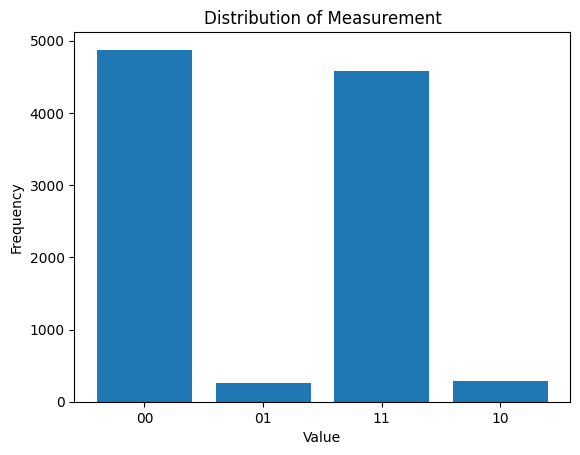

In [8]:
# Print the counts as Python dictionary form.

print(f"Counts: {counts}.")

# Plot the distribution on a histogram.

import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Measurement")
plt.show()

## References

* [Qiskit Documentation](https://qiskit.org/documentation/): Comprehensive guides and API references
* [IBM Quantum](https://quantum-computing.ibm.com/): Access to quantum systems and development tools